# Solving a real problem with RNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


Try to predict the milk production of a farm

In [2]:
df = pd.read_csv('data/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [3]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

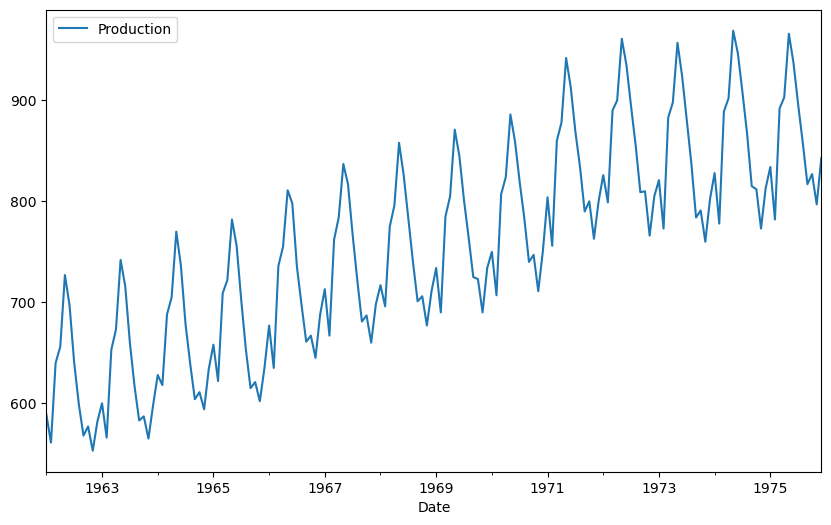

In [4]:
df.plot(figsize=(10,6))

In [5]:
len(df)

168

Split in train and testing for evaluation

In [6]:
train = df.iloc[:156]
test = df.iloc[156:]

Scale the data for more accurate results

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [9]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [10]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

Define the parameters of the generator

We will be using 12 months

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [12]:
generator[0]

(array([[[0.08653846],
         [0.01923077],
         [0.20913462],
         [0.24759615],
         [0.41826923],
         [0.34615385],
         [0.20913462],
         [0.11057692],
         [0.03605769],
         [0.05769231],
         [0.        ],
         [0.06971154]]]),
 array([[0.11298077]]))

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN

In [39]:
# define model
n_features=1

model = Sequential()
model.add(SimpleRNN(20, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [40]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 20)                440       
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [41]:
# fit model
model.fit(generator,epochs=20)

Epoch 1/20
144/144 [==============================] - 2s 6ms/step - loss: 0.0162
Epoch 2/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0104
Epoch 3/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0086
Epoch 4/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0073
Epoch 5/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0069
Epoch 6/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0058
Epoch 7/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0051
Epoch 8/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0040
Epoch 9/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0030
Epoch 10/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0025
Epoch 11/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0021
Epoch 12/20
144/144 [==============================] - 1s 6ms/step - loss: 0.0016
Epoch 13/20
144/144 [====

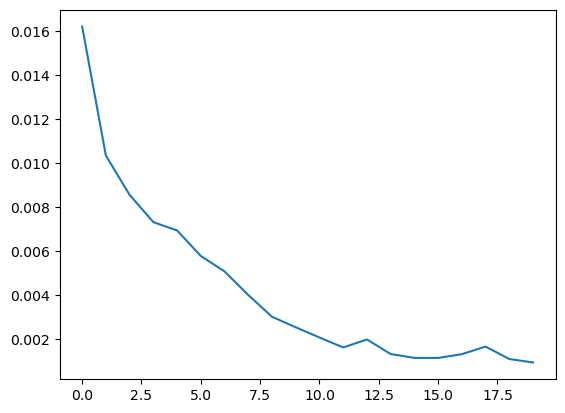

In [42]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Lets classify using the model.
- For the first output, we build a matrix with the last 12 values on train set
- On every iteration:
    - Calculate the ouput value
    - Put the output value as the last value in the next input

In [43]:
last_train_batch = scaled_train[-12:]
print(last_train_batch)

[[0.66105769]
 [0.54086538]
 [0.80769231]
 [0.83894231]
 [1.        ]
 [0.94711538]
 [0.85336538]
 [0.75480769]
 [0.62980769]
 [0.62259615]
 [0.52884615]
 [0.625     ]]


In [44]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [45]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 128ms/step


array([[0.66072077]], dtype=float32)

In [46]:
scaled_test[0]

array([0.67548077])

Lets predict the whole test set

In [47]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [48]:
test_predictions

[array([0.66072077], dtype=float32),
 array([0.57081354], dtype=float32),
 array([0.7822558], dtype=float32),
 array([0.8392302], dtype=float32),
 array([0.9970132], dtype=float32),
 array([0.9786358], dtype=float32),
 array([0.92311734], dtype=float32),
 array([0.7917201], dtype=float32),
 array([0.6722813], dtype=float32),
 array([0.6324631], dtype=float32),
 array([0.5492507], dtype=float32),
 array([0.5683131], dtype=float32)]

In [49]:
true_predictions = scaler.inverse_transform(test_predictions)

In [50]:
test['Predictions'] = true_predictions

<Axes: xlabel='Date'>

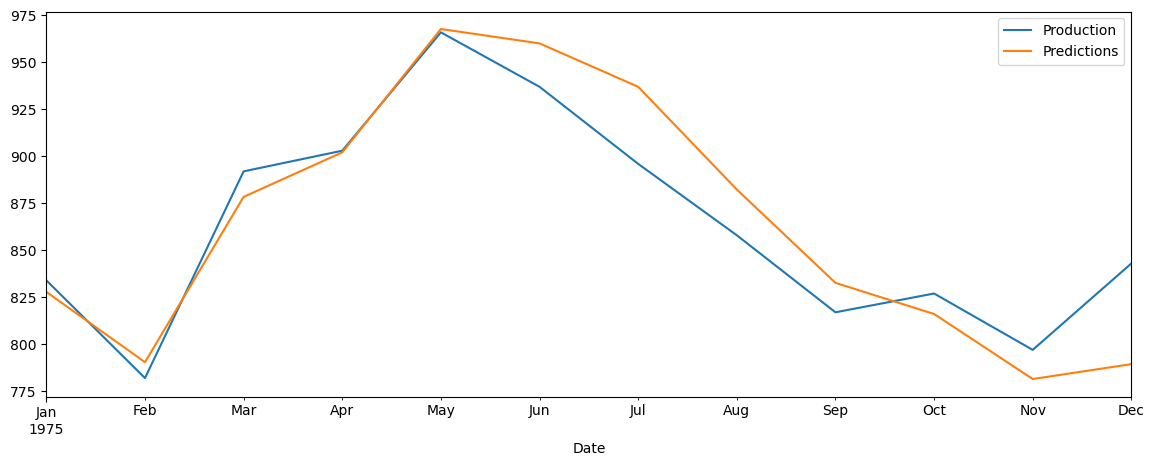

In [51]:
test.plot(figsize=(14,5))

In [31]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

61.27466523985421


## Influence on the number of previous values to use

Lets create a function to simplify the tests

In [52]:
def test_number_of_inputs(n_input, epochs=20):
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

    # define model
    model = Sequential()
    model.add(SimpleRNN(20, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(generator,epochs=epochs, verbose=False)

    test_predictions = []

    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(test)):

        # get the prediction value for the first batch
        current_pred = model.predict(current_batch, verbose=False)[0]

        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    true_predictions = scaler.inverse_transform(test_predictions)
    test['Predictions'] = true_predictions

    from sklearn.metrics import mean_squared_error
    from math import sqrt
    rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
    test.plot(figsize=(14,5))
    print(rmse)

42.154684774760995


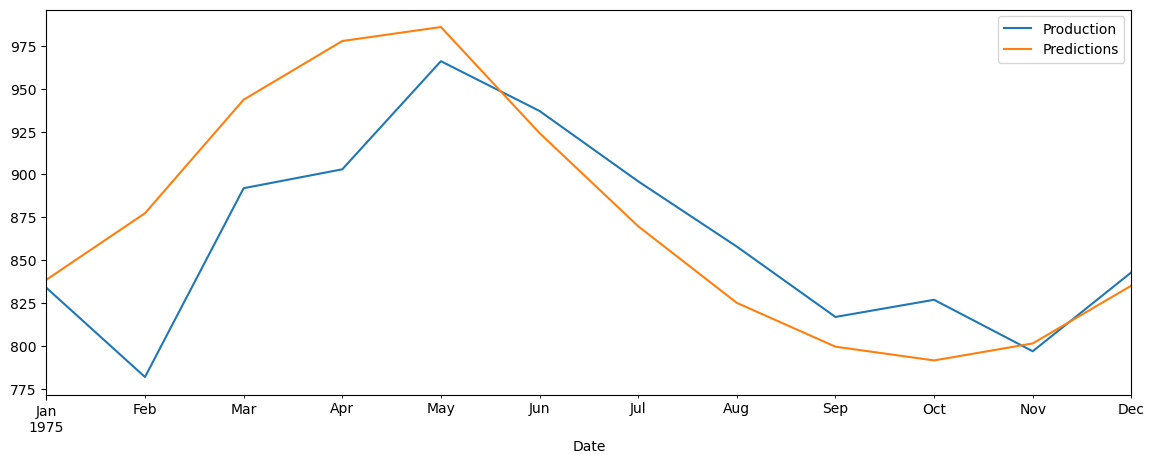

In [53]:
test_number_of_inputs(8)

62.61178064316811


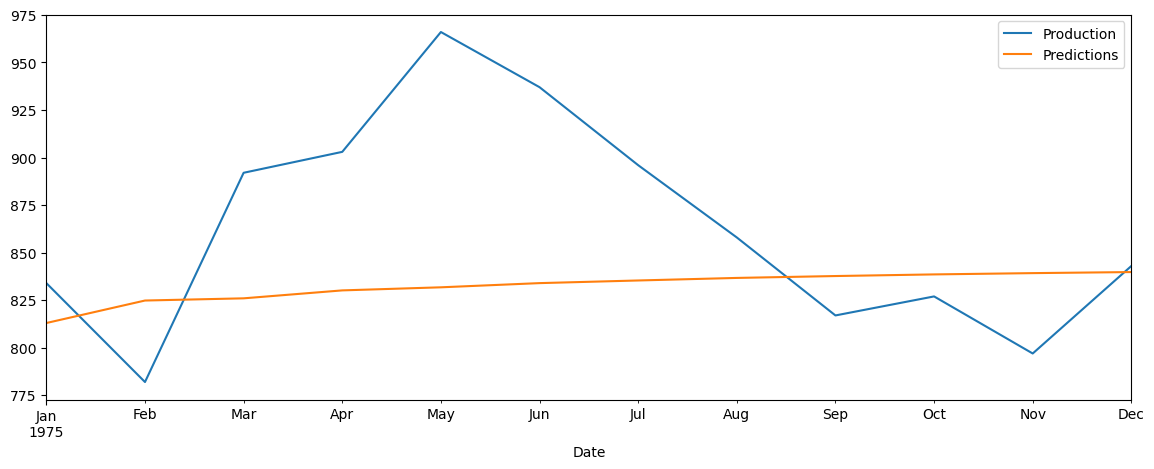

In [54]:
test_number_of_inputs(4)

159.30631619799763


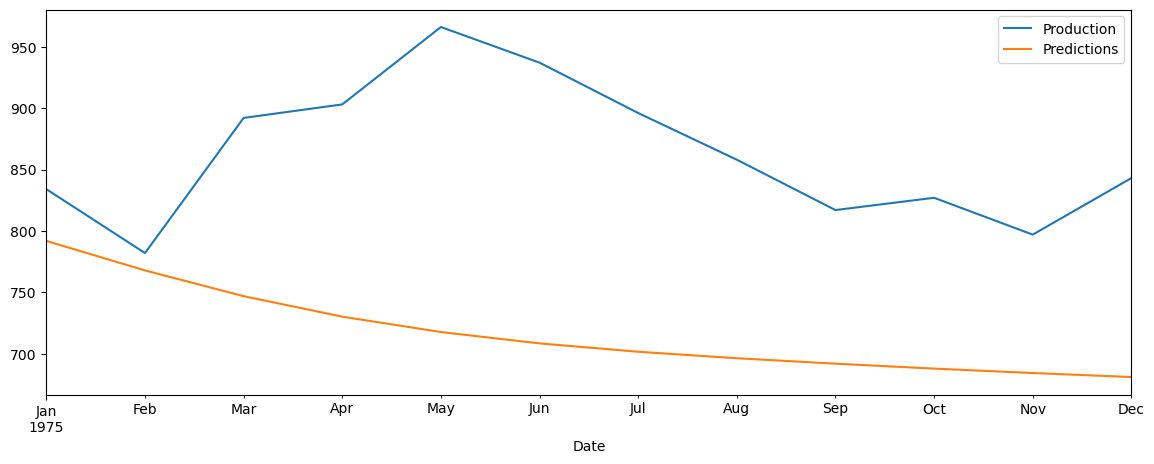

In [55]:
test_number_of_inputs(2)

## How to know the proper lag?

[1.         0.88959913 0.7705281  0.60571496 0.46559789 0.4026568
 0.34754473 0.38566523 0.4260745  0.53606568 0.66495207 0.75023661
 0.82874649 0.72814342 0.61638771 0.46389369 0.33403081 0.27471084
 0.22395313 0.25830412 0.2938183  0.39183631]


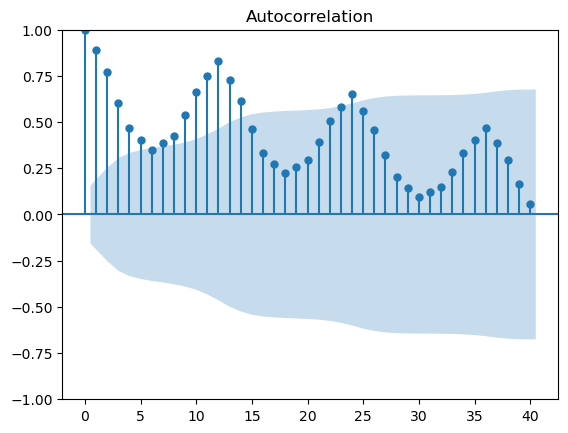

In [61]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# Calculate autocorrelation coefficients
autocorrelation_coefficients = acf(scaled_train)

# Optionally, print the coefficients
print(autocorrelation_coefficients)

# Plot Autocorrelation
plot_acf(your_time_series, lags=40)  # You can adjust the number of lags as needed
plt.show()


51.53307801002847


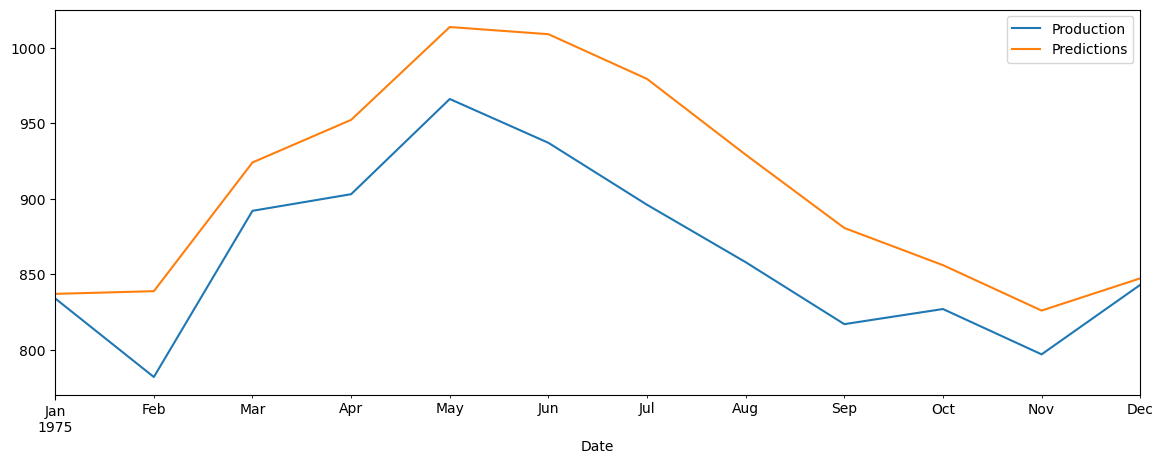

In [62]:
test_number_of_inputs(12)

## Now, lets increment the forecasting horizon

In [63]:
train = df.iloc[:100]
test = df.iloc[100:]

In [64]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

73.44873656354245


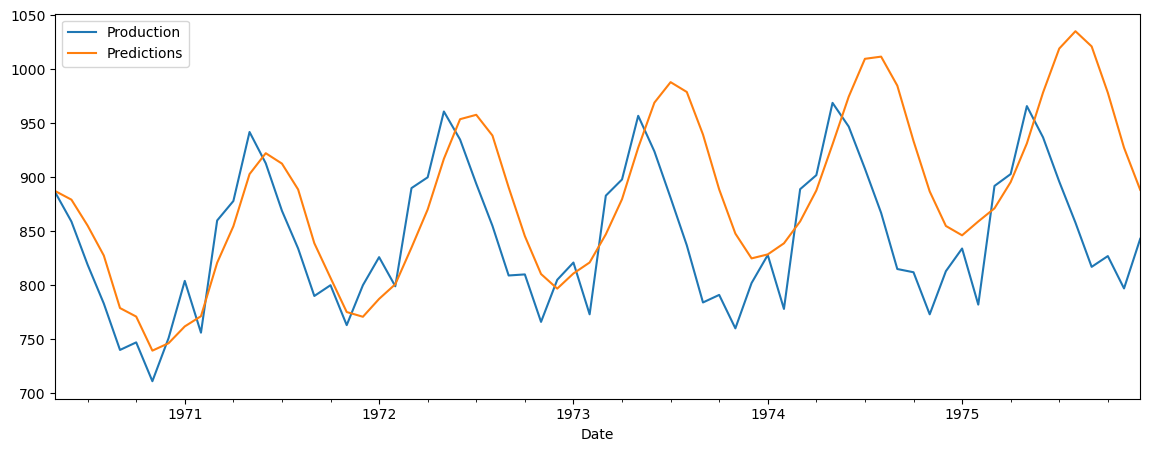

In [65]:
test_number_of_inputs(12)